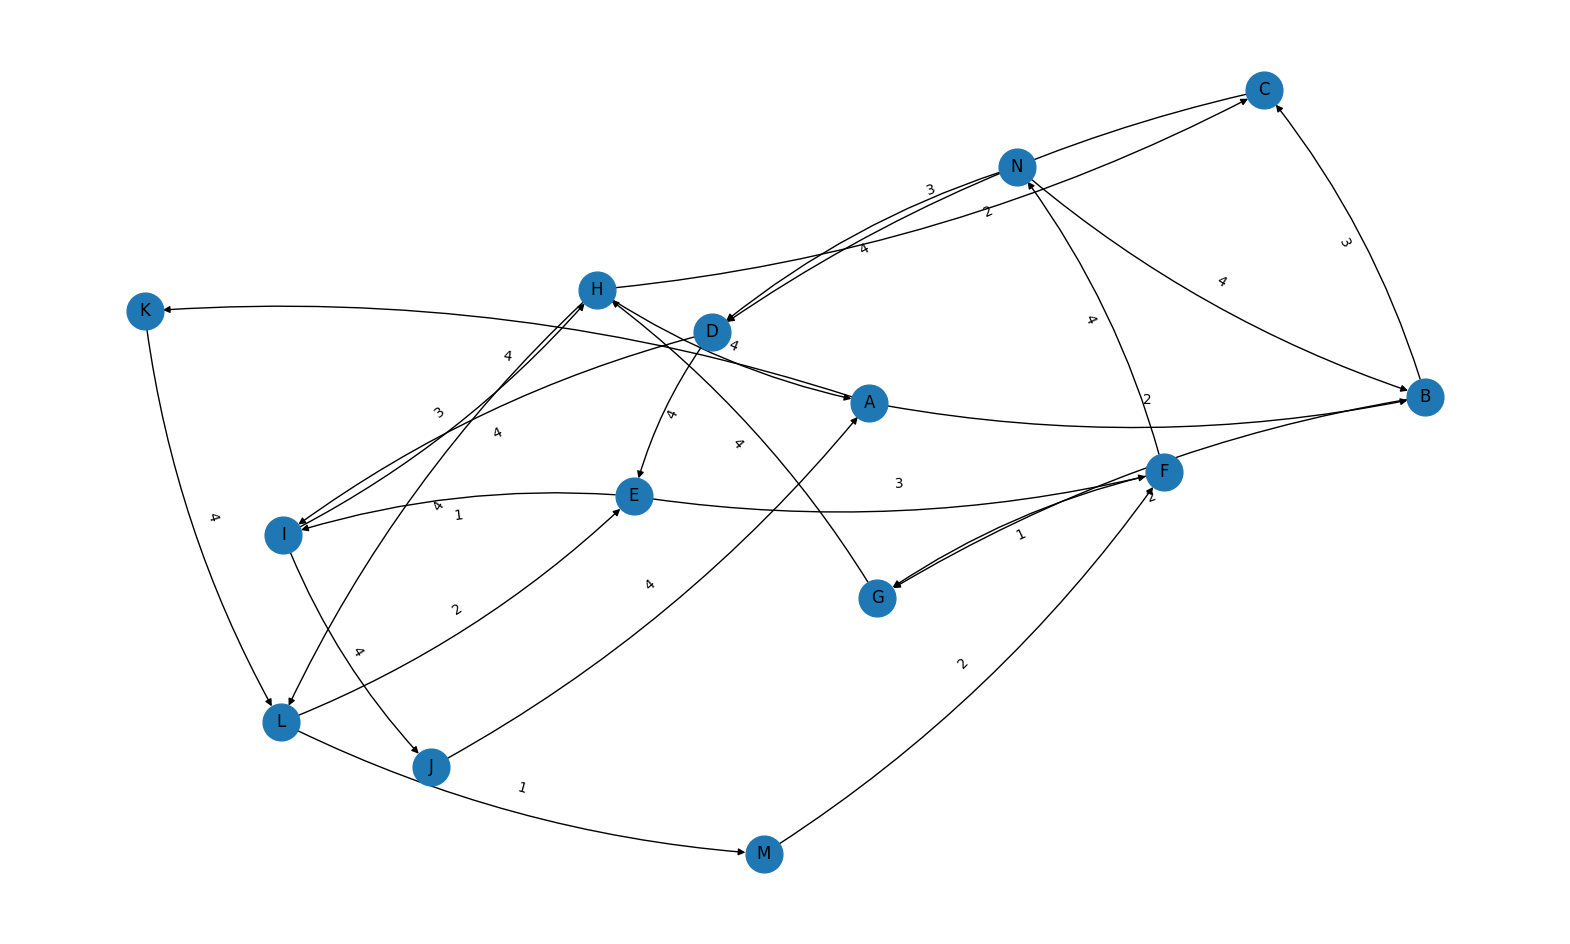

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

routes = pd.read_csv('routes.csv')

edge_list = []

for index,row in routes.iterrows():
    edge_list.append((row['from'],row['to'],{'distance':row['distance']}))

G = nx.DiGraph(edge_list)

pos = nx.spring_layout(G, k=0.8)
edge_labels = nx.get_edge_attributes(G, "distance")

plt.figure(figsize=(20, 12))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,label_pos=0.5)
nx.draw(G, pos=pos, node_size=700, with_labels=True,connectionstyle="arc3, rad = 0.1")

In [2]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd

routes = pd.read_csv('routes.csv')

model = pyo.ConcreteModel()

# Sets and Parameters
model.d       = {}
model.in_set  = {}
model.out_set = {}

for index,row in routes.iterrows():
    model.d[(row['from'],row['to'])] = row['distance']
    try:
        model.in_set[row['to']].append(row['from'])
    except:
        model.in_set[row['to']] = [row['from']]
        
    try:    
        model.out_set[row['from']].append(row['to'])
    except:
        model.out_set[row['from']] = [row['to']]

        
begin_node = 'A'
end_node   = 'F'

path_node = set(routes['from'].to_list()).intersection(set(routes['to'].to_list()))

path_node = path_node - set([begin_node]) - set([end_node])

# Variables
model.x = pyo.Var(list(zip(routes['from'],routes['to'])), within=pyo.Binary)

# Objective Function
model.obj = pyo.Objective(expr = sum([model.x[j['from'],j['to']]*j['distance'] for i,j in routes.iterrows()]),
                          sense=pyo.minimize)


# Constarints
model.C1 = pyo.Constraint(expr = sum([model.x[begin_node,node] for node in model.out_set[begin_node]]) == 1)

model.C2 = pyo.Constraint(expr = sum([model.x[node,end_node] for node in model.in_set[end_node]]) == 1)


model.C3 = pyo.ConstraintList()
for node in path_node:
    model.C3.add(expr = sum([model.x[node,i] for i in model.out_set[node]]) == sum([model.x[j,node] for j in model.in_set[node]]))
    
#solve
opt = SolverFactory('gurobi')
model.results = opt.solve(model)

model.pprint()
print('\n\nOF:',pyo.value(model.obj))
for route in list(zip(routes['from'],routes['to'])):
    if pyo.value(model.x[route[0], route[1]]) >= 0.9:
        print('Route activated: %s-%s' % (route[0], route[1]))

2 Set Declarations
    C3_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   12 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   24 : {('A', 'B'), ('A', 'K'), ('H', 'A'), ('J', 'A'), ('B', 'C'), ('B', 'G'), ('N', 'B'), ('C', 'D'), ('H', 'C'), ('D', 'E'), ('D', 'I'), ('N', 'D'), ('E', 'I'), ('E', 'F'), ('L', 'E'), ('F', 'G'), ('F', 'N'), ('M', 'F'), ('G', 'H'), ('H', 'L'), ('I', 'H'), ('I', 'J'), ('K', 'L'), ('L', 'M')}

1 Var Declarations
    x : Size=24, Index=x_index
        Key        : Lower : Value : Upper : Fixed : Stale : Domain
        ('A', 'B') :     0 :   0.0 :     1 : False : False : Binary
        ('A', 'K') :     0 :   1.0 :     1 : False : False : Binary
        ('B', 'C') :     0 :  -0.0 :     1 : False : False : Binary
        ('B', 'G') :     0 :   0.0 :     1 : False :